# Dead reckoning based on gyroscope data

In [27]:
import numpy as np
import pandas as pd

import scipy.signal

from numba import jit

from ahrs.filters import Madgwick
from ahrs.filters import Mahony
from ahrs.common.orientation import acc2q

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [28]:
path = "./data/test_imu_B_2_1.csv"
imu_df = pd.read_csv(path)
imu_df.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,35752794502900,440160,-9.7878,-0.1089,-0.5791,-0.1393,-0.1087,-0.0831,23.22


In [29]:
# create equal sampling rate

# Calculate the average time difference
average_time_difference = int((imu_df['arduino_timestamp'].iloc[-1] - imu_df['arduino_timestamp'].iloc[0]) / len(imu_df))

# Create a new DataFrame with equal time intervals
new_time_column = pd.Series(range(imu_df['arduino_timestamp'].iloc[0], imu_df['arduino_timestamp'].iloc[-1] + 1, int(average_time_difference)))
new_df = pd.DataFrame({'arduino_timestamp': new_time_column})

# Merge the original DataFrame with the new DataFrame based on the time column
df = pd.merge_asof(new_df, imu_df, on='arduino_timestamp')

# Interpolate the missing values
df = df.interpolate()

# Reset the index if needed
imu_df = df.reset_index(drop=True)
imu_df

,arduino_timestamp,host_timestamp,ax,ay,az,gx,gy,gz,temperature
0,440160,35752794502900,-9.7878,-0.1089,-0.5791,-0.1393,-0.1087,-0.0831,23.22
1,440171,35752805800900,-9.7998,-0.0945,-0.5862,-0.1051,-0.1136,-0.0623,23.23
2,440182,35752805800900,-9.7998,-0.0945,-0.5862,-0.1051,-0.1136,-0.0623,23.23
3,440193,35752816840800,-9.8154,-0.0622,-0.4822,-0.1063,-0.1100,-0.0586,23.23
4,440204,35752828197400,-9.7986,-0.1256,-0.5647,-0.2187,-0.1319,-0.0440,23.25
...,...,...,...,...,...,...,...,...,...
4465,489275,35801905990300,-9.8285,-0.1555,0.3182,0.0147,-0.0672,-0.0232,23.53
4466,489286,35801917236700,-9.8237,-0.1519,0.3278,0.0147,-0.0672,-0.0269,23.53
4467,489297,35801928657800,-9.8225,-0.1352,0.3230,0.0147,-0.0635,-0.0464,23.49
4468,489308,35801939873500,-9.8201,-0.1460,0.3314,0.0134,-0.0574,-0.0586,23.55


In [30]:
n = len(imu_df)
t = imu_df["arduino_timestamp"].values * 1e-3
a_s = imu_df[["ax", "ay", "az"]].values
g_s = imu_df[["gx", "gy", "gz"]].values

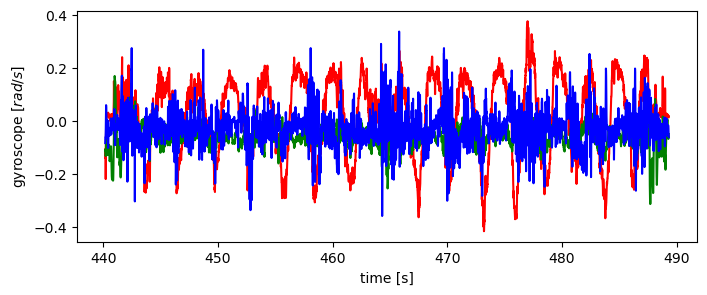

In [31]:
# Show gyroscope in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, g_s[:, 0], c="r")
ax.plot(t, g_s[:, 1], c="g")
ax.plot(t, g_s[:, 2], c="b")
ax.set_xlabel("time [s]")
ax.set_ylabel("gyroscope $[rad/s]$")
plt.show()

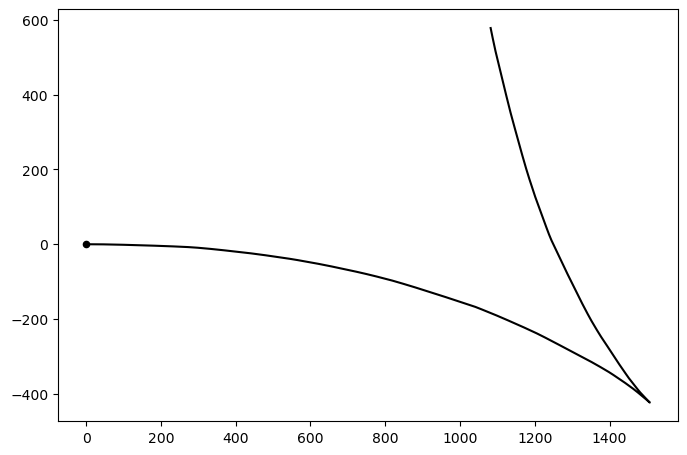

In [32]:
initial_position = np.array([0, 0, 0], dtype= "float64")  # [latitude, longitude, altitude]
orientation = np.array([0, 0, 0], dtype= "float64")  # [roll, pitch, yaw]
position = np.zeros_like(g_s)
position[0] = initial_position
for i in range(1, len(g_s)):

    # Integrate angular velocity to obtain orientation changes
    orientation_change = g_s[i] * (t[i]-t[i-1])
 

    # Update orientation
    orientation += orientation_change

    # Update position based on orientation changes
    position_change = np.array([
        np.cos(orientation[2]) * np.cos(orientation[1]),  # change in latitude
        np.sin(orientation[2]) * np.cos(orientation[1]),  # change in longitude
        np.sin(orientation[1])  # change in altitude
    ])

    position[i] = position[i-1] + position_change
    # Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(position[:, 0], position[:, 1], c="k")
ax.scatter(position[0, 0], position[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()

In [33]:
# correct gyroscope data according to calibration
def corrected_gyr(w_i, u_0):

    y_yz = u_0[0]
    y_zy = u_0[1]
    y_xz = u_0[2]
    y_zx = u_0[3]
    y_xy = u_0[4]
    y_yx = u_0[5]

    Y = np.eye(3)
    Y[0,1] = -y_yz
    Y[0,2] = y_zy
    Y[1,2] = -y_zx
    Y[1,0] = y_xz
    Y[2,0] = -y_xy
    Y[2,1] = y_yx

    S = np.diag([u_0[6], u_0[7], u_0[8]])

    a_O = Y @ S @ w_i
    return a_O

params = np.array([-1.16219459,  4.21499289, -1.10084924,  3.18973475,  1.24116692, 0.87719272,  2.52939341, -0.74496146,  3.27684755])

gyr_s_c = np.apply_along_axis(corrected_gyr, axis=1, arr=g_s, u_0= params)

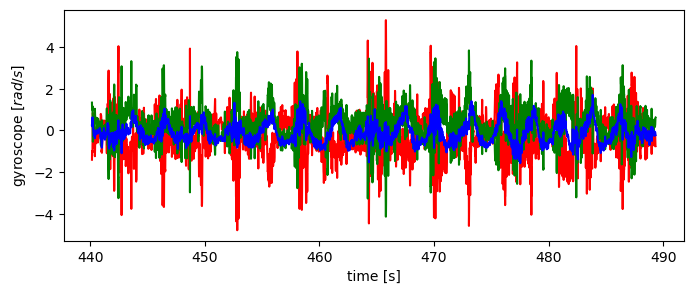

In [34]:
# Show corrected gyroscope in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, gyr_s_c[:, 0], c="r")
ax.plot(t, gyr_s_c[:, 1], c="g")
ax.plot(t, gyr_s_c[:, 2], c="b")
ax.set_xlabel("time [s]")
ax.set_ylabel("gyroscope $[rad/s]$")
plt.show()

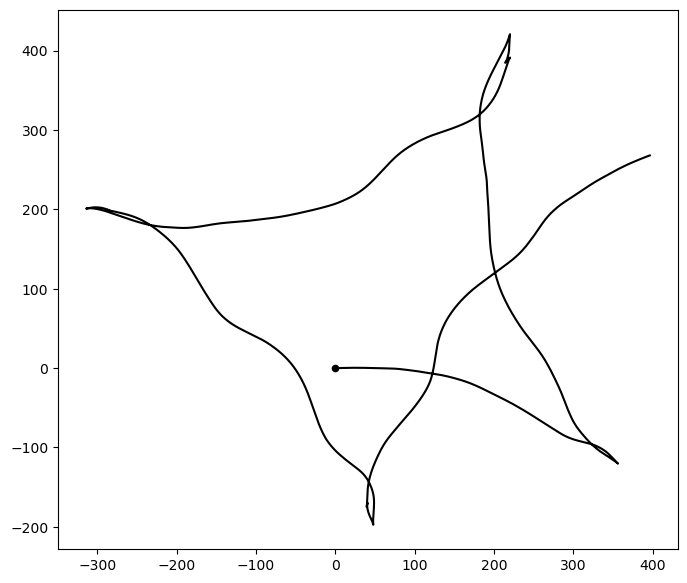

In [35]:


initial_position = np.array([0, 0, 0], dtype= "float64")  # [latitude, longitude, altitude]
orientation = np.array([0, 0, 0], dtype= "float64")  # [roll, pitch, yaw]
position = np.zeros_like(gyr_s_c)
position[0] = initial_position
for i in range(1, len(gyr_s_c)):

    # Integrate angular velocity to obtain orientation changes
    orientation_change = gyr_s_c[i] * (t[i]- t[i-1])

    # Update orientation
    orientation += orientation_change

    # Update position based on orientation changes
    position_change = np.array([
        np.cos(orientation[2]) * np.cos(orientation[1]),  # change in latitude
        np.sin(orientation[2]) * np.cos(orientation[1]),  # change in longitude
        np.sin(orientation[1])  # change in altitude
    ])

    position[i] = position[i-1] + position_change
    # Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(position[:, 0], position[:, 1], c="k")
ax.scatter(position[0, 0], position[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()

In [36]:
# parameters from the paper 
#m = [[0.9998, -0.0149, -0.0218],[0.0003, 1.0007, 0.0433],[-0.0048, 0.0121, 1.0004]]
m = [[0.9998, -0.0149, -0.0218],[0.0003, 1.0007, 0.0433],[-0.0048, 0.0121, 1.0004]]
s = np.diag([0.8786, 0.9703, 1.0460])

u_0 = [0.0112,-0.0211, 0.0040, -0.0010, 0.0270, 0.0151]

y_yz = u_0[0]
y_zy = u_0[1]
y_xz = u_0[2]
y_zx = u_0[3]
y_xy = u_0[4]
y_yx = u_0[5]

Y = np.eye(3)
Y[0,1] = -y_yz
Y[0,2] = y_zy
Y[1,2] = -y_zx
Y[1,0] = y_xz
Y[2,0] = -y_xy
Y[2,1] = y_yx


In [37]:
def correct(gyr):
    return Y @ s @ gyr

gyr_s_c_paper = np.apply_along_axis(correct, axis=1, arr=g_s)

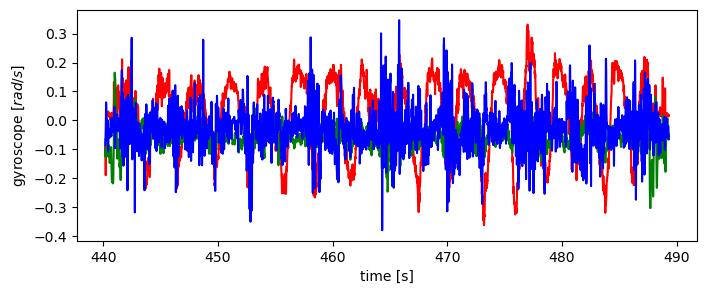

In [38]:
# Show gyroscope in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t,gyr_s_c_paper[:, 0], c="r")
ax.plot(t, gyr_s_c_paper[:, 1], c="g")
ax.plot(t, gyr_s_c_paper[:, 2], c="b")
ax.set_xlabel("time [s]")
ax.set_ylabel("gyroscope $[rad/s]$")
plt.show()